# GD animation

In [313]:
import jax
from jax import grad, random
from jax import numpy as jnp
from matplotlib import pyplot as plt

# Generate data
N = 50
w_optim = jnp.array([3.0, 4.0])

RNG = random.PRNGKey(228)

x_points = random.uniform(RNG, (N, 1)) - 0.5
b = jnp.ones_like(x_points)
X_data = jnp.hstack((x_points,b))

RNG, _ = random.split(RNG)
sigma = 2e-1
y_data = X_data @ w_optim + sigma*random.normal(RNG, (N, ))
w_lstsq = jnp.linalg.lstsq(X_data, y_data)[0]

In [314]:
# Generate optimization problem
def f(w, X=X_data, y=y_data):
    N, d = X.shape
    return 1/(2*N)*jnp.linalg.norm(X @ w - y)**2

N_ITER = 300
LR = 3e-1

def gd(f, w_0, n_iter=N_ITER, lr=LR):
    w = w_0
    g = jax.jit(grad(f))
    metrics = {
        "fs": [],
        "gs": [],
        "ws": [],
    }
    metrics["fs"].append(f(w))
    metrics["gs"].append(jnp.linalg.norm(g(w)))
    metrics["ws"].append(w)

    for i_iter in range(N_ITER):
        w -= lr*g(w)
        metrics["fs"].append(f(w))
        metrics["gs"].append(jnp.linalg.norm(g(w)))
        metrics["ws"].append(w)
    
    return metrics

RNG, _ = random.split(RNG)
# w_0 = random.normal(RNG, (2,))
w_0 = jnp.array([5.5, 1.5])

metrics = gd(f, w_0)

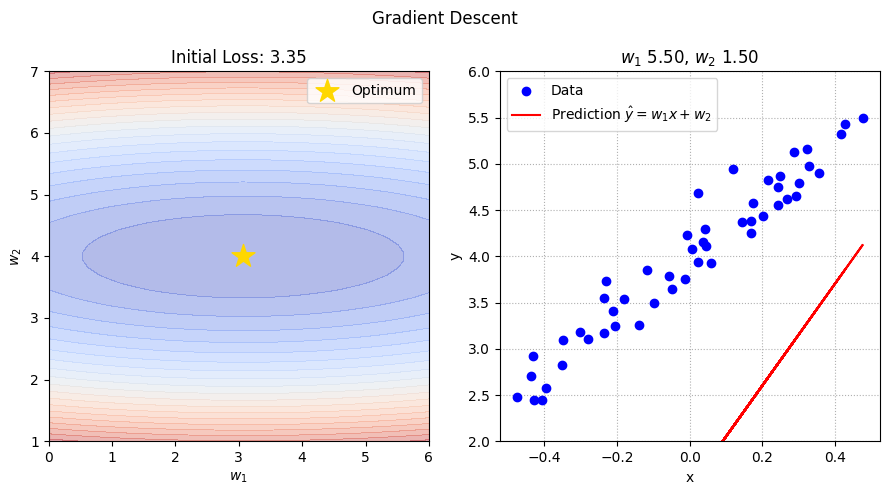

In [315]:
from matplotlib import gridspec, pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

fig = plt.figure(figsize=(9, 5))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 1])
plt.suptitle("Gradient Descent")

# Set up the contour plot for the loss surface
axl = fig.add_subplot(spec[0])
x = w_optim[0] + np.linspace(-3, 3, 50)
y = w_optim[1] + np.linspace(-3, 3, 50)
X, Y = np.meshgrid(x, y)
Z = np.array([f(np.array([x, y])) for x, y in zip(X.flatten(), Y.flatten())]).reshape(X.shape)

# Use contourf for filled contour lines, adjust levels and cmap as needed
contour = axl.contourf(X, Y, Z, levels=20, alpha=.4, cmap='coolwarm')
trajectory, = axl.plot([], [], 'm-', lw=1.5)  # Trajectory line
current_iteration, = axl.plot([], [], color='purple')

axl.set_xlabel(r'$w_1$')
axl.set_ylabel(r'$w_2$')
axl.scatter(w_lstsq[0], w_lstsq[1], color='gold', marker='*', s=300, label='Optimum')
axl.set_title(f'Initial Loss: {f(w_0):.2f}')
axl.legend()

# Set up the 2D plot for the data and predictions
axr = fig.add_subplot(spec[1])
axr.scatter(X_data[:, 0], y_data, label="Data", color='blue')
prediction, = axr.plot(X_data[:, 0], X_data @ w_0, label=r"Prediction $\hat{y} = w_1 x + w_2$", color='red')
axr.set_xlabel('x')
axr.set_ylabel('y')
axr.set_title(f'$w_1$ {w_0[0]:.2f}, $w_2$ {w_0[1]:.2f}')
axr.set_ylim(2,6)
axr.grid(linestyle=":")
axr.legend()
axr.set_axisbelow(True)

fig.tight_layout()
fig.subplots_adjust()

# Define the animation function for updating the contour and prediction line
def animate(i):
    global contour, trajectory, current_iteration
    w = metrics["ws"][i]
    ws = jnp.array(metrics["ws"][:i+1])  # All past weights up to current

    # Update the trajectory line
    trajectory.set_data(np.array(ws)[:, 0], np.array(ws)[:, 1])

    # Update data plot with selected batch
    if current_iteration:
        current_iteration.remove()
    current_iteration = axl.scatter(w[0], w[1], color='purple', zorder=100)
    axl.set_title(f'Loss value {metrics["fs"][i]:.2f}')
    
    prediction.set_data([X_data[:, 0], X_data @ w])
    axr.set_title(f'$w_1$ {w[0]:.2f}, $w_2$ {w[1]:.2f}')
    return prediction,

# Animate the plots
ani = FuncAnimation(
    fig,
    animate,
    # frames=10,
    frames=len(metrics["ws"]),
    interval=10
)

plt.show()


In [218]:
# This took about 1 minute on Macbook Pro with M1 Pro
ani.save('GD_simple.mp4',fps=30, dpi=400)

In [316]:
# This took about 0.5 minute on Macbook Pro with M1 Pro
video = ani.to_html5_video()

In [317]:
from IPython import display
html = display.HTML(video)
display.display(html)
# plt.close()    

# SGD detailed explanation

In [318]:
import jax
from jax import grad, random
from jax import numpy as jnp
from matplotlib import pyplot as plt

# Generate data
N = 100
w_optim = jnp.array([3.0, 4.0])

RNG = random.PRNGKey(228)

x_points = random.uniform(RNG, (N, 1)) - 0.5
b = jnp.ones_like(x_points)
X_data = jnp.hstack((x_points,b))

RNG, _ = random.split(RNG)
sigma = 2e-1
y_data = X_data @ w_optim + sigma*random.normal(RNG, (N, ))
w_lstsq = jnp.linalg.lstsq(X_data, y_data)[0]

In [326]:
# Generate optimization problem
def f(w, X=X_data, y=y_data):
    N, d = X.shape
    return 1/(2*N)*jnp.linalg.norm(X @ w - y)**2

N_ITER = 20
batch_size = 2
LR = 1e-0
RNG = random.PRNGKey(0)

def sgd(f, w_0, RNG=RNG, n_iter=N_ITER, lr=LR, batch_size=batch_size):
    w = w_0
    metrics = {
        "fs": [],
        "ws": [],
        "gs": [],
        "w_lstsqs": [],
        "indices": []
    }

    for i_iter in range(n_iter):
        RNG, _ = random.split(RNG)
        indices = random.choice(RNG, X_data.shape[0], shape=(batch_size,), replace=False)
        X_batch = X_data[indices]
        y_batch = y_data[indices]
        w_lstsq = jnp.linalg.lstsq(X_batch, y_batch)[0]
        g = grad(f)(w, X_batch, y_batch)
        w -= lr*g
        metrics["fs"].append(f(w))
        metrics["ws"].append(w)
        metrics["gs"].append(g)
        metrics["indices"].append(indices)
        metrics["w_lstsqs"].append(w_lstsq)
    
    return metrics

RNG, _ = random.split(RNG)
w_0 = jnp.array([5.5, 1.5])

metrics = sgd(f, w_0)

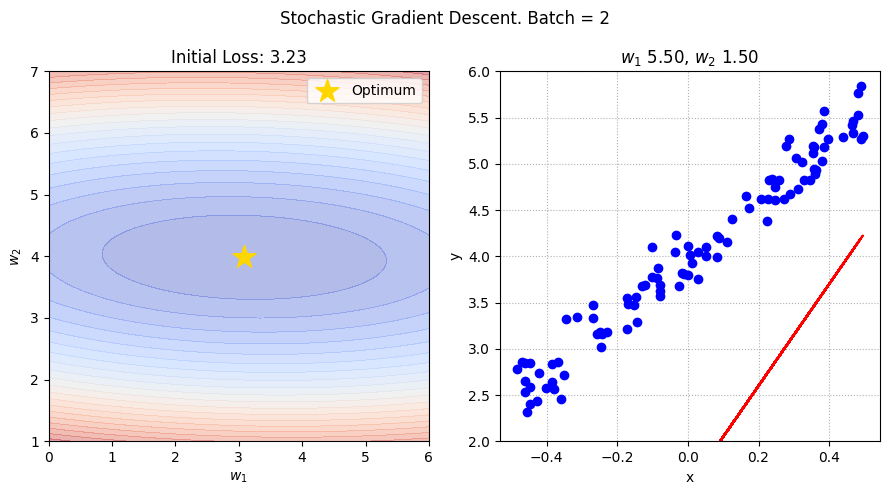

In [327]:
from matplotlib import gridspec, pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
import numpy as np

# Define a helper function for plotting arrows
def draw_arrow(ax, start, end, color='green'):
    arrow = FancyArrowPatch(start, end, color=color, arrowstyle='->', mutation_scale=5)
    ax.add_patch(arrow)
    return arrow

fig = plt.figure(figsize=(9, 5))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 1])
plt.suptitle(f"Stochastic Gradient Descent. Batch = {batch_size}")

# Set up the contour plot for the loss surface
axl = fig.add_subplot(spec[0])
x = w_optim[0] + np.linspace(-3, 3, 100)
y = w_optim[1] + np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([f(np.array([x, y])) for x, y in zip(X.flatten(), Y.flatten())]).reshape(X.shape)

# Use contourf for filled contour lines, adjust levels and cmap as needed
contour = axl.contourf(X, Y, Z, levels=20, alpha=.4, cmap='coolwarm')
trajectory, = axl.plot([], [], 'm-', lw=1.5)  # Trajectory line
current_iteration, = axl.plot([], [], color='purple')

axl.set_xlabel(r'$w_1$')
axl.set_ylabel(r'$w_2$')
axl.scatter(w_lstsq[0], w_lstsq[1], color='gold', marker='*', s=300, label='Optimum')
axl.set_title(f'Initial Loss: {f(w_0):.2f}')
axl.legend()

# Set up the 2D plot for the data and predictions
axr = fig.add_subplot(spec[1])
axr.scatter(X_data[:, 0], y_data, label="Data", color='blue')
prediction, = axr.plot(X_data[:, 0], X_data @ w_0, label=r"Prediction $\hat{y} = w_1 x + w_2$", color='red')
batch_prediction, = axr.plot([], [], label=r"Batch Prediction", color='green')
axr.set_xlabel('x')
axr.set_ylabel('y')
axr.set_title(f'$w_1$ {w_0[0]:.2f}, $w_2$ {w_0[1]:.2f}')
axr.set_ylim(2,6)
axr.grid(linestyle=":")
axr.set_axisbelow(True)

fig.tight_layout()
fig.subplots_adjust()

batch_scatter = None
lstsq_marker = None
gradient_arrow = None
quadratic_contour = None

# Define the animation function for updating the contour and prediction line
def animate(i):
    global contour, batch_scatter, lstsq_marker, gradient_arrow, \
    quadratic_contour, trajectory, current_iteration
    step = i // 2  # Convert frame index to SGD step index
    w = metrics["ws"][step] 
    g = metrics["gs"][step]
    indices = metrics["indices"][step]
    w_lstsq = metrics["w_lstsqs"][step]
    def f_batch(w, X=X_data[indices], y=y_data[indices]):
        N, d = X.shape
        return 1/(2*N)*jnp.linalg.norm(X @ w - y)**2
    if i % 2 == 0:
        if i == 0:
            w_prev = w_0
            ws = [w_0]
            if current_iteration:
                current_iteration.remove()
            current_iteration = axl.scatter(w_0[0], w_0[1], color='purple', zorder=100)
        else:
            w_prev = metrics["ws"][step-1]
            ws = jnp.vstack([w_0, metrics["ws"][:step+1]])
        # Update contour plot with SGD step
        if lstsq_marker:
            lstsq_marker.remove()
        lstsq_marker = axl.scatter(w_lstsq[0], w_lstsq[1], color='green', marker='*', label='Batch Optimum')

        # Update data plot with selected batch
        if batch_scatter:
            batch_scatter.remove()
        batch_scatter = axr.scatter(X_data[indices, 0], y_data[indices], color='green', label="Batch Data")

        batch_prediction.set_data([X_data[:, 0], X_data @ w_lstsq])

        if gradient_arrow:
            gradient_arrow.remove()
            gradient_arrow = None

        # Add new gradient arrow
        grad_end = w_prev - g  # Adjust the scaling factor as needed for visibility
        gradient_arrow = draw_arrow(axl, w_prev, grad_end)

        if quadratic_contour:
            for coll in quadratic_contour.collections:
                coll.remove()
            quadratic_contour = None

        # Plot quadratic contour
        z_val = f_batch(w_prev)
        levels = [z_val]
        Z_batch = np.array([f_batch(np.array([x, y])) for x, y in zip(X.flatten(), Y.flatten())]).reshape(X.shape)
        quadratic_contour = axl.contour(X, Y, Z_batch, levels=levels, colors='green')

    else:
        # Update the scatter plot on the left to show the current weights
        # Update the trajectory line
        ws = jnp.vstack([w_0, metrics["ws"][:step+1]])
        trajectory.set_data(np.array(ws)[:, 0], np.array(ws)[:, 1])

        # Update data plot with selected batch
        if current_iteration:
            current_iteration.remove()
        current_iteration = axl.scatter(w[0], w[1], color='purple', zorder=100)
        # axl.scatter(w[0], w[1], color='purple', zorder=100)
        prediction.set_data([X_data[:, 0], X_data @ w])
        axl.set_title(f'Loss value {metrics["fs"][step]:.2f}')
        axr.set_title(f'$w_1$ {w[0]:.2f}, $w_2$ {w[1]:.2f}')
    
    axl.legend()
    axr.legend(loc="upper left")

    axl.set_xlim(x.min(),x.max())
    axl.set_ylim(y.min(),y.max())
    return prediction, batch_scatter, lstsq_marker

# Animate the plots
ani = FuncAnimation(
    fig,
    animate,
    # frames = 20,
    frames=2*len(metrics["ws"])-1,
    interval=100
)

plt.show()


In [312]:
# This took about 0.3 minutes on Macbook Pro with M1 Pro
ani.save('Detailed_SGD.mp4',fps=2, dpi=400)

/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/ipykernel_61576/2396902975.py:110: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 1. In a future JAX release this will be an error.
  ws = jnp.vstack([w_0, metrics["ws"][:step+1]])
/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/ipykernel_61576/2396902975.py:75: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 1. In a future JAX release this will be an error.
  ws = jnp.vstack([w_0, metrics["ws"][:step+1]])


In [328]:
# This took about 0.5 minute on Macbook Pro with M1 Pro
video = ani.to_html5_video()

from IPython import display
html = display.HTML(video)
display.display(html)
# plt.close()    

/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/ipykernel_61576/2617400470.py:110: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 1. In a future JAX release this will be an error.
  ws = jnp.vstack([w_0, metrics["ws"][:step+1]])
/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/ipykernel_61576/2617400470.py:75: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 1. In a future JAX release this will be an error.
  ws = jnp.vstack([w_0, metrics["ws"][:step+1]])


# SGD quick animation

In [329]:
import jax
from jax import grad, random
from jax import numpy as jnp
from matplotlib import pyplot as plt

# Generate data
N = 100
w_optim = jnp.array([3.0, 4.0])

RNG = random.PRNGKey(228)

x_points = random.uniform(RNG, (N, 1)) - 0.5
b = jnp.ones_like(x_points)
X_data = jnp.hstack((x_points,b))

RNG, _ = random.split(RNG)
sigma = 2e-1
y_data = X_data @ w_optim + sigma*random.normal(RNG, (N, ))
w_lstsq = jnp.linalg.lstsq(X_data, y_data)[0]

In [330]:
# Generate optimization problem
def f(w, X=X_data, y=y_data):
    N, d = X.shape
    return 1/(2*N)*jnp.linalg.norm(X @ w - y)**2

N_ITER = 300
batch_size = 2
LR = 1e0
RNG = random.PRNGKey(0)

def sgd(f, w_0, RNG=RNG, n_iter=N_ITER, lr=LR, batch_size=batch_size):
    w = w_0
    metrics = {
        "fs": [],
        "ws": [],
        "gs": [],
        "w_lstsqs": [],
        "indices": []
    }

    for i_iter in range(n_iter):
        RNG, _ = random.split(RNG)
        indices = random.choice(RNG, X_data.shape[0], shape=(batch_size,), replace=False)
        X_batch = X_data[indices]
        y_batch = y_data[indices]
        w_lstsq = jnp.linalg.lstsq(X_batch, y_batch)[0]
        g = grad(f)(w, X_batch, y_batch)
        w -= lr*g
        metrics["fs"].append(f(w))
        metrics["ws"].append(w)
        metrics["gs"].append(g)
        metrics["indices"].append(indices)
        metrics["w_lstsqs"].append(w_lstsq)
    
    return metrics

RNG, _ = random.split(RNG)
w_0 = jnp.array([5.5, 1.5])

metrics = sgd(f, w_0)

/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


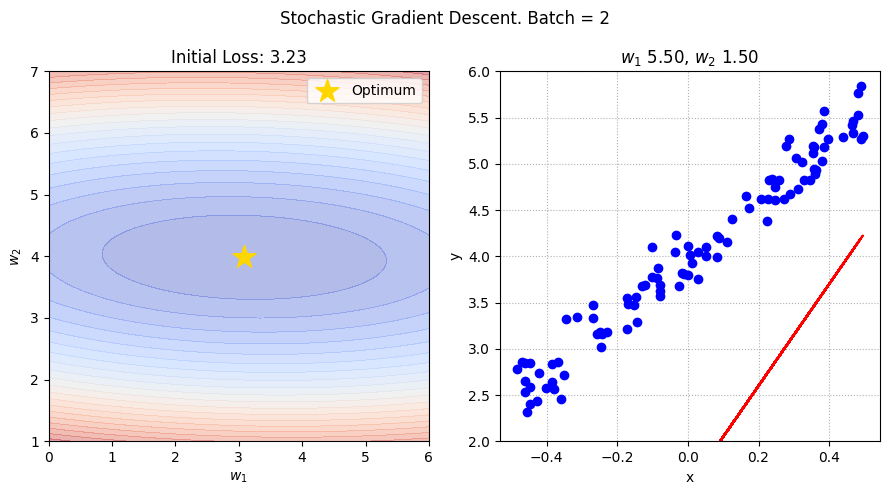

In [332]:
from matplotlib import gridspec, pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
import numpy as np

# Define a helper function for plotting arrows
def draw_arrow(ax, start, end, color='green'):
    arrow = FancyArrowPatch(start, end, color=color, arrowstyle='->', mutation_scale=5)
    ax.add_patch(arrow)
    return arrow

plt.rcParams['figure.dpi'] = 100
fig = plt.figure(figsize=(9, 5))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 1])
plt.suptitle(f"Stochastic Gradient Descent. Batch = {batch_size}")

# Set up the contour plot for the loss surface
axl = fig.add_subplot(spec[0])
x = w_optim[0] + np.linspace(-3, 3, 100)
y = w_optim[1] + np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([f(np.array([x, y])) for x, y in zip(X.flatten(), Y.flatten())]).reshape(X.shape)

# Use contourf for filled contour lines, adjust levels and cmap as needed
contour = axl.contourf(X, Y, Z, levels=20, alpha=.4, cmap='coolwarm')
trajectory, = axl.plot([], [], 'm-', lw=1.5)  # Trajectory line
current_iteration, = axl.plot([], [], color='purple')

axl.set_xlabel(r'$w_1$')
axl.set_ylabel(r'$w_2$')
axl.scatter(w_lstsq[0], w_lstsq[1], color='gold', marker='*', s=300, label='Optimum')
axl.set_title(f'Initial Loss: {f(w_0):.2f}')
axl.legend()
axr.legend(loc="upper left")

axl.set_xlim(x.min(),x.max())
axl.set_ylim(y.min(),y.max())

# Set up the 2D plot for the data and predictions
axr = fig.add_subplot(spec[1])
axr.scatter(X_data[:, 0], y_data, label="Data", color='blue')
prediction, = axr.plot(X_data[:, 0], X_data @ w_0, label=r"Prediction $\hat{y} = w_1 x + w_2$", color='red')
batch_prediction, = axr.plot([], [], label=r"Batch Prediction", color='green')
axr.set_xlabel('x')
axr.set_ylabel('y')
axr.set_title(f'$w_1$ {w_0[0]:.2f}, $w_2$ {w_0[1]:.2f}')
axr.set_ylim(2,6)
axr.grid(linestyle=":")
axr.set_axisbelow(True)

fig.tight_layout()
fig.subplots_adjust()

batch_scatter = None
lstsq_marker = None
gradient_arrow = None
quadratic_contour = None

# Define the animation function for updating the contour and prediction line
def animate(frame):
    global contour, batch_scatter, trajectory, current_iteration

    if frame == 0:
        w = w_0
        ws = [w_0]
        axl.set_title(f'Loss value {f(w):.2f}')
    else: 
        i = frame-1
        w = metrics["ws"][i] 
        ws = jnp.vstack([w_0, metrics["ws"][:i+1]])
        axl.set_title(f'Loss value {metrics["fs"][i]:.2f}')


    # Update the trajectory line
    trajectory.set_data(np.array(ws)[:, 0], np.array(ws)[:, 1])

    # Update data plot with selected batch
    if current_iteration:
        current_iteration.remove()
    current_iteration = axl.scatter(w[0], w[1], color='purple', zorder=100)

    prediction.set_data([X_data[:, 0], X_data @ w])
    
    axr.set_title(f'$w_1$ {w[0]:.2f}, $w_2$ {w[1]:.2f}')

    return prediction, batch_scatter, lstsq_marker, current_iteration

# Animate the plots
ani = FuncAnimation(
    fig,
    animate,
    # frames = 20,
    frames=len(metrics["ws"])-1,
    interval=20
)

plt.show()


In [302]:
# This took about 0.7 minutes on Macbook Pro with M1 Pro
ani.save('SGD_simplest.mp4',fps=30, dpi=400)

/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/ipykernel_61576/625708053.py:70: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 1. In a future JAX release this will be an error.
  ws = jnp.vstack([w_0, metrics["ws"][:i+1]])


In [333]:
# This took about 0.5 minute on Macbook Pro with M1 Pro
video = ani.to_html5_video()

from IPython import display
html = display.HTML(video)
display.display(html)
# plt.close()    

/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/ipykernel_61576/587040703.py:70: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 1. In a future JAX release this will be an error.
  ws = jnp.vstack([w_0, metrics["ws"][:i+1]])
